In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import median,mean
%matplotlib inline
from pylab import rcParams
import sympy as sym
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from scipy import stats as s
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import sklearn.cross_validation as crv
from sklearn.linear_model import LinearRegression

In [2]:
def read_acc(file):
    data_acc = pd.read_csv(file,sepx=' ',header=None)
   
    data_acc = data_acc.rename(columns={data_acc.columns[0]:'X_acc', data_acc.columns[1]:'Y_acc', data_acc.columns[2]:'Z_acc',data_acc.columns[3]:'TimeStamp'} )
    
    return data_acc

In [3]:
#fix NaN
def fix_NaN(data):
    for  c  in  data.columns:
        col = data[c]  #'X'列から1列ずつ見る
        for r in range(len(data)):  #1行ずつ見る
            if col[r] == 0.0:       #0値が見つかれば
                data.iloc[r][c] = 'NaN' #'NaN'を代入
    mc_clean = data.interpolate()
    mc_clean = mc_clean.fillna(0)
    return mc_clean

In [4]:
#線形加速度を得る
def linear_acc(data):
    alpha = 0.9
    for  c  in  ['X_acc','Y_acc','Z_acc']:
        g = 0  
        col = data[c]           #'X'列から1列ずつ見る
        for r in range(len(data)):         #1行ずつ見る
            #Isolate the force of gravity with the low-pass filter.
            g = alpha*g + (1-alpha) * col[r]
            #Remove the gravity contribution with the high-pass filter.
            linear = col[r] - g
            data.iloc[r][c] = linear
        linear_acc = data
    return linear_acc

In [5]:
def obtain_statistical_feature(window):
    #features = np.array(np.array(np.var(window, axis=0)))
    #features=np.array(np.array(np.mean(window-np.mean(window), axis=0)))
    features=np.array(np.array(np.mean(window-np.median(window), axis=0))) 
    features=np.append(features, np.array(np.std(window, axis=0))) 
    features=np.append(features, np.array(np.var(window, axis=0)))
    features=np.append(features, np.array(s.skew(window, axis=0)))
    features=np.append(features, np.array(s.kurtosis(window, axis=0)))
    features=np.append(features, np.array(get_tw_variance(window)))
    return features.reshape(1,len(features))

In [6]:
def get_tw_variance(window):
    total_cols = window.shape[1]
    tw_var = []
    for i in range (total_cols):
        column = window.iloc[:,i]
        tw_var.append(get_tw_col_var(column))
    return tw_var


def get_tw_col_var(column):
    mean = np.mean(column)
    total = len(column)
    
    v_sum = 0
    for i in range(total):
        w = np.exp(-0.5*(total-i))
        #print("el peso", w, "indice", i, "total", total)
        v = w*np.square(column.iloc[i]-mean)
        v_sum += v
    return v_sum

In [8]:
def real_accel(*sensor_n):
    x = np.empty([0,3*6])
    y = np.empty([0,])
    print(sensor_n)
    #Read all mocap data
    subjects =  ["01","02","03","04","05","06","07","08","09","10","11","12"]
    actions = ["01","02","03","04","05","06","07","08","09","10","11"]
    for i in sensor_n: 
        for subject in subjects:
            for action in actions:
                for record in range(1,6):
                    try:
                        data = read_acc('/Users/takeshin/ws/BerkeleyMHAD/Accelerometer/Shimmer0'+str(i)+'/acc_h0'+str(i)+'_s'+str(subject)+'_a'+str(action)+'_r0'+str(record)+'.txt')
                        print('acc_h0'+str(i)+'_s'+str(subject)+'_a'+str(action)+'_r0'+str(record)+'.txt')
                        data = fix_NaN(data)
                        data = linear_acc(data)  
                        sf = obtain_statistical_feature(data[['X_acc','Y_acc','Z_acc']])
                        x =np.append(x,sf, axis=0)
                        y = np.append(y,[action], axis=0)
                    except FileNotFoundError:
                        pass

    return x, y   

In [ ]:
x_real,y_real = real_accel(1)

In [ ]:
x_real.shape

In [ ]:
def ml_ar(X,y):
    x_train, x_test, y_train, y_test = crv.train_test_split(X, y, test_size=0.30, random_state=42)
    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    conf = confusion_matrix(y_test, y_predict)
    print (accuracy_score(y_test, y_predict) ) 
    actions = ["01","02","03","04","05","06","07","08","09","10","11"]
    print(classification_report(y_test, y_predict, target_names=actions))
    print(conf)

In [ ]:
ml_ar(x_real,y_real) 

In [ ]:
def ml_ar2(X,y):                              
    #Try classifier
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('clf', SVC(kernel='linear')))
    model = Pipeline(estimators)
    
    seed = 11
    kf = KFold(n_splits=3, random_state=seed, shuffle=True)
    accuracy = [] 
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        acc_train = model.score(X_train, y_train)
        acc_test = model.score(X_test, y_test)
        accuracy.append(acc_test)
        #print('Accuracy on training set: {:.2f}'
        #  .format(model.score(X_train, y_train)))
        #print('Accuracy on test set: {:.2f}'
        #  .format(model.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        conf = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred,average='macro') 
        recall = recall_score(y_test, y_pred,average='macro')
        print("*Accuracy* train:",acc_train, "test:",acc_test)
        #print(conf)
       # print ("precision:",precision,"recall:",recall)
        actions = ["01","02","03","04","05","06","07","08","09","10","11"]
        #actions = ["Jumping in place","Jumping jacks","Bending-hands up all the way down","Punching(boxing)","Waving-two hands","Waving - one hand (right)","Clapping hands","Throwing a ball","09","10","11"]
        print(classification_report(y_test, y_pred, target_names=actions))
        print("-----------")
    print("*test_ave*",sum(accuracy)/len(accuracy))

In [ ]:
ml_ar2(x_real,y_real) 

# ポッケ位置

In [ ]:
#plt.title("")
w = 0.2  #棒の幅
y1 = np.array([])
y2 = np.array([0.86, 0.84, 0.94,0.95,0.46,0.58,0.90,0.94,0.93,0.79,0.84])

x = np.arange(len(y1))       #データ数に合わせて横軸を準備

plt.bar(x, y1, width=w, label='virtual', align="center")
plt.bar(x + w, y2, width=w, label='real', align="center")
plt.legend(loc="best")    
plt.xlabel("action")
plt.ylabel("f1-score")

# X軸の目盛りを科目名にする　日本語を使う場合はfontproperties=fp
plt.xticks(x + w/2, ['01','02','03','04','05','06','07','08','09','10','11'])
plt.show()

In [ ]:
#plt.title("")
w = 0.2  #棒の幅
y1 = np.array([78.9,76.9,100,90,52.9,50,69.2,91.7,66.7,83.3,50])
y2 = np.array([72.2,54.5,100,92.9,35,42.9,90,83.3,100,75,86.7])

x = np.arange(len(y1))       #データ数に合わせて横軸を準備

plt.bar(x, y1, width=w, label='virtual', align="center")
plt.bar(x + w, y2, width=w, label='real', align="center")
plt.legend(loc="best")    
plt.xlabel("action")
plt.ylabel("accuracy[%]")

# X軸の目盛りを科目名にする　日本語を使う場合はfontproperties=fp
plt.xticks(x + w/2, ['01','02','03','04','05','06','07','08','09','10','11'])
plt.show()

# 手首位置

In [ ]:
#plt.title("")
w = 0.2  #棒の幅
y1 = np.array([])
y2 = np.array([0.97, 1.0, 0.97,1.0,1.0,0.98,1.00,0.73,1.0,0.98,0.82])

x = np.arange(len(y1))       #データ数に合わせて横軸を準備

plt.bar(x, y1, width=w, label='virtual', align="center")
plt.bar(x + w, y2, width=w, label='real', align="center")
plt.legend(loc="best")    
plt.xlabel("action")
plt.ylabel("f1-score")

# X軸の目盛りを科目名にする　日本語を使う場合はfontproperties=fp
plt.xticks(x + w/2, ['01','02','03','04','05','06','07','08','09','10','11'])
plt.show()

## (腰)モーションキャプチャデータで行動認識（ダウンサンプリングを行わなった場合）

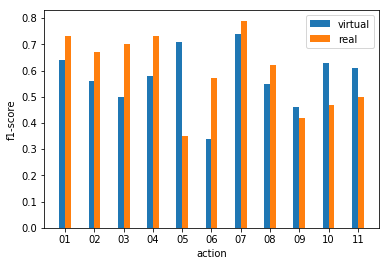

In [13]:
#plt.title("")
w = 0.2  #棒の幅
y1 = np.array([0.64,0.56,0.50,0.58,0.71,0.34,0.74,0.55,0.46,0.63,0.61])
y2 = np.array([0.73, 0.67, 0.70,0.73,0.35,0.57,0.79,0.62,0.42,0.47,0.50])

x = np.arange(len(y1))       #データ数に合わせて横軸を準備

plt.bar(x, y1, width=w, label='virtual', align="center")
plt.bar(x + w, y2, width=w, label='real', align="center")
plt.legend()    
plt.xlabel("action")
plt.ylabel("f1-score")

# X軸の目盛りを科目名にする　日本語を使う場合はfontproperties=fp
plt.xticks(x + w/2, ['01','02','03','04','05','06','07','08','09','10','11'])
plt.show()